# 1a. Create master bias

The first step in data redution is to combine all the individual `raw_bias_exposures` in the `raw_bias_folder` directory to create a single `master_bias` and save it as a FITS file called `master_bias_filename`.

## Initialise parameters

In [7]:
import os  # to manipulate files and directories
import numpy as np  # mathematics
from astropy.io import fits  # FITS files
from matplotlib import pyplot as plt  # plotting

data_folder = '.'  # location of the observational data within your hard disk (by default, this directory)
calib_folder = os.path.join(data_folder, 'raw', 'calib')  # location of the raw science exposures
raw_bias_folder = os.path.join(calib_folder, 'bias')  # location of the bias file
output_filename = os.path.join(calib_folder, 'master_bias.fits')  # name of the file where you intend to save the master bias

## Read raw exposures

In [8]:
raw_bias_exposures = []  # List containing all individual exposures

for filename in os.listdir(raw_bias_folder):  # Loop over all files in the directory
    
    if os.path.splitext(filename)[1] == '.fits':  # FITS file extension
        print("Opening", filename)
        hdu = fits.open(os.path.join(raw_bias_folder, filename))  # HDU = Header/Data Unit (standard FITS nomenclature)
        raw_bias_exposures.append(hdu[0].data)  # Add the data to the `raw_exposures` list
        '''
        TODO:
        - show individual exposures?
        '''
        if hdu[0].header['EXPTIME'] > 0:
            raise FileNotFoundError("Non-null exposure time: t_exp = "+hdu[0].header['EXPTIME'])
    else:
        print("Skipping", filename)

n_files = len(raw_bias_exposures)
print(n_files, "files read")

Opening uamA_0002.fits
Opening uamA_0001.fits
2 files read


## Compute bias

If there is just one bias exposure, there is not much to do: that is the bias map. If there are more than two, ... (TODO: explanation)

In [11]:
if n_files == 0:
    raise FileNotFoundError("No FITS files were found in "+raw_bias_folder)

else:
    bias_map = np.nanmedian(raw_bias_exposures, axis=0)

    if n_files == 1:
        print("WARNING: only one bias file was found.")

    else:
        noise_map = np.nanvar(raw_bias_exposures, axis=0)
    
        # Test whether the median bias map is uniform
        map_median = np.nanmedian(bias_map)  # estimate of a uniform value accross the image
        map_variance = np.nanvar(bias_map)  # map_variance = signal_variance + noise_variance
        noise_variance = np.nanmedian(noise_map)  # estimator of the typical noise variance
        signal_variance = map_variance - noise_variance
        if signal_variance <= 0.:
            probability_uniform = 1.
        else:
            probability_uniform = np.exp(-signal_variance/noise_variance)
        uniform = map_median*np.ones_like(bias_map)
        print(f'median bias={map_median}, probability_uniform={probability_uniform}, (signal_variance={signal_variance:.2f}, noise_variance={noise_variance:.2f}')
        bias_map = probability_uniform*uniform + (1-probability_uniform)*bias_map  # weighted average

median bias=672.0, probability_uniform=0.0, (signal_variance=138173.65, noise_variance=25.00


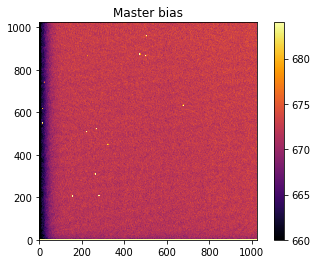

In [12]:
# TODO: Proper plots
plt.imshow(bias_map, origin='lower', vmin=np.nanpercentile(bias_map, 5), vmax=np.nanpercentile(bias_map, 95), cmap='inferno')
plt.title('Master bias')
plt.colorbar()
plt.show()

In [14]:
hdu = fits.PrimaryHDU(bias_map.astype(np.float32))
hdu.writeto(output_filename, overwrite=True)
print("Master bias saved to", output_filename)

Master bias saved to ./raw/calib/master_bias.fits
